In [1]:
from datasets import load_dataset, Dataset
from IPython.display import display
from PIL import Image
import numpy as np
import pandas as pd
import pycountry
from pprint import pprint
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from matplotlib.lines import Line2D


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Model imports
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Pytorch imports
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dl_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(f"I will use deep learning models using {dl_device}!")

I will use deep learning models using cuda!


In [4]:
# Load the vgg16 model which will be used to extract image embeddings
vgg_16_model = models.vgg16(pretrained=True).to(dl_device)
vgg_16_model.eval()

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [76]:
# Copy the model without the final classifier layer
vgg_embedding_model = torch.nn.Sequential(*list(vgg_16_model.children())[:-1]).to(dl_device)

In [6]:
def alpha2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

# Loading Data and exploring it

#### We will apply to only 5 countries in the reserach for easier analysis, faster training times and specified answers
Israel, USA, Japan, Nigeria, Denmark 


In [17]:
# Exploration and pre-processing functions and parameters

# Select only Israel, USA, Japan, Nigeria and Denmark as countries from the dataset
SELECTED_COUNTRIES = ('IL','US','JP','NG','DE')

def keep_samples_by_label(sample):
    return sample["label"] in SELECTED_COUNTRIES


def build_array_df_from_dataset(dataset, to_grey_scale: bool = False) -> pd.DataFrame:
    def process_sample(sample):
        return {
            "image_array": np.array(sample["image"].resize((128, 128)) if not to_grey_scale else sample["image"].convert("L").resize((128,128))),
            "label": sample["label"]
        }    

    processed_filtered_ds = dataset.map(process_sample)
    df = pd.DataFrame({
    "image_array": processed_filtered_ds["image_array"],
    "label": processed_filtered_ds["label"]
    })

    return df

def flatten_image_dataframe(df, image_col='image_array', label_col='label'):
    """
    Converts a DataFrame with grayscale or RGB images into a flat format:
    - Each pixel/channel becomes a column (unnamed numeric index).
    - The label is added as the final column.

    Parameters:
        df (pd.DataFrame): DataFrame with image vectors and labels.
        image_col (str): Column name containing image data.
        label_col (str): Column name containing labels.

    Returns:
        pd.DataFrame: Flattened DataFrame with pixel values and label.
    """
    def flatten_image(img):
        arr = np.array(img)
        if arr.ndim == 2:
            return arr.flatten()
        elif arr.ndim == 3:
            return arr.transpose(2, 0, 1).flatten()
        else:
            raise ValueError(f"Unsupported image shape: {arr.shape}")

    # Flatten images
    flat_pixels = df[image_col].apply(flatten_image).to_list()
    pixel_df = pd.DataFrame(flat_pixels)

    # Append label as last column
    pixel_df[label_col] = df[label_col].values

    return pixel_df

In [7]:
# Load the datasets
# Those datasets are related to the images only. Will be used for training DL and MLP models.
dataset = load_dataset("nateraw/country211")
dataset_train, dataset_validation, dataset_test = dataset["train"], dataset["validation"], dataset["test"]
datasets = (dataset_train, dataset_validation, dataset_test)

In [8]:
# This is a callable that saves the mapping of labels to their string representation
label2country = dataset_train.features["label"].int2str

# This is the inverse of the above
country2label = dataset_train.features["label"].str2int

def count_labels(label_column: np.ndarray) -> dict:
    labels_as_strings = list(label2country(label_column))

    counts = Counter(labels_as_strings)
    return dict(counts)

In [13]:
# This line of code filters the given datasets to ones that only contain countries from the SELECTED_COUNTRIES list.
datasets_filtered = tuple(dataset.filter(lambda sample: label2country(sample["label"]) in SELECTED_COUNTRIES) for dataset in datasets)

Filter: 100%|███████████████████████████████████████████████████████████████████| 21100/21100 [01:06<00:00, 315.42 examples/s]


In [14]:
# Those datasets should be used when working with the deep learning models (VGG, ResNet).
dataset_train_filtered, dataset_validation_filtered, dataset_test_filtered = datasets_filtered

In [15]:
print("Dataset Shapes Before   ->  After")
print(f"Train:       {dataset_train.shape} -> {dataset_train_filtered.shape}")
print(f"Validation:  {dataset_validation.shape} -> {dataset_validation_filtered.shape}")
print(f"Test:        {dataset_test.shape} -> {dataset_test_filtered.shape}")

Dataset Shapes Before   ->  After
Train:       (31650, 2) -> (750, 2)
Validation:  (10550, 2) -> (250, 2)
Test:        (21100, 2) -> (500, 2)


### With the new datasets of filtered countries, we can begin working on the questions

However, in order to work with traditional ML, which in our case will be SVM, AdaBoost and Random Forest, we need an array of features. For that the data will be transformed to arrays, and in the case of colored images, 3d arrays. 

3D arrays while representative, pose an issue with training for traditional ML. It is usually recommended to use 1d arrays that represent features. In the case of images, each pixel can be seen as a feature but it has the trade-off of losing relational information of neighboring pixels. Therefore, flattering will be required, but at a cost of model accuracy which we will later see.

In the following section, we will create 2 types of dataframes: One of RGB images as array, and one as greyscale images as array. Those will also be flattened in order to support training them with ML tasks and with exploring by PCA 

In [19]:
# Build the relevant dataframes for future data exploration and analysis 

print("Building RGB dataframes")
data_frames_rgb = tuple(build_array_df_from_dataset(filtered_ds, to_grey_scale=False) for filtered_ds in datasets_filtered)

print("Flattening RGB dataframes")
data_frames_rgb_flattened = tuple(flatten_image_dataframe(filtered_ds_rgb) for filtered_ds_rgb in data_frames_rgb)

print("Building greyscale dataframes")
data_frames_grey = tuple(build_array_df_from_dataset(filtered_ds, to_grey_scale=True) for filtered_ds in datasets_filtered)

print("Flattening greyscale dataframes")
data_frames_grey_flattened = tuple(flatten_image_dataframe(filtered_ds_grey) for filtered_ds_grey in data_frames_grey)

# NOTE: The new dataframes are also filtered and following data-frames should be assumed as filtered except the very first datasets imported.

Building RGB dataframes
Flattening RGB dataframes
Building greyscale dataframes
Flattening greyscale dataframes


In [20]:
df_train_rgb, df_validation_rgb, df_test_rgb = data_frames_rgb
df_train_rgb_flattened, df_validation_rgb_flattened, df_test_rgb_flattened = data_frames_rgb_flattened

df_train_grey, df_validation_grey, df_test_grey = data_frames_grey
df_train_grey_flattened, df_validation_grey_flattened, df_test_grey_flattened = data_frames_grey_flattened

In [26]:
# Several assertions to check order of labels stays the same

assert df_train_rgb['label'].equals(df_train_rgb_flattened['label'])
assert df_validation_rgb['label'].equals(df_validation_rgb_flattened['label'])
assert df_test_rgb['label'].equals(df_test_rgb_flattened['label'])

assert df_train_grey['label'].equals(df_train_grey_flattened['label'])
assert df_validation_grey['label'].equals(df_validation_grey_flattened['label'])
assert df_test_grey['label'].equals(df_test_grey_flattened['label'])

In [27]:
# Checking data instability

print(f"Images train data label counts:      {count_labels(dataset_train_filtered["label"])}")
print(f"Images validation data label counts: {count_labels(dataset_validation_filtered["label"])}")
print(f"Images test data label counts:       {count_labels(dataset_test_filtered["label"])}")

print()

print(f"DF-RGB train data label counts:      {count_labels(df_train_rgb["label"])}")
print(f"DF-RGB validation data label counts: {count_labels(df_validation_rgb["label"])}")
print(f"DF-RGB test data label counts:       {count_labels(df_test_rgb["label"])}")

print()

print(f"DF-grey train data label counts:      {count_labels(df_train_grey["label"])}")
print(f"DF-grey validation data label counts: {count_labels(df_validation_grey["label"])}")
print(f"DF-grey test data label counts:       {count_labels(df_test_grey["label"])}")


Images train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
Images validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
Images test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}

DF-RGB train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
DF-RGB validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
DF-RGB test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}

DF-grey train data label counts:      {'DE': 150, 'IL': 150, 'JP': 150, 'NG': 150, 'US': 150}
DF-grey validation data label counts: {'DE': 50, 'IL': 50, 'JP': 50, 'NG': 50, 'US': 50}
DF-grey test data label counts:       {'DE': 100, 'IL': 100, 'JP': 100, 'NG': 100, 'US': 100}


## Q1

This leads to exploring one of the questions: Can we present if the countries are similar and which are different based on the features alone? In order to visualize it we need to use PCA, which is a dimentionality reduction technique that preserves the variance with a fixed number of dimentions. We can reduce to 3 or 2 dimentions but retain the information.

In addition, we will also present calculations that determine which countries are most similar, and which are most different. This and PCA will be applied with both the feature vectors but also with image embedding we will introduce later

In [25]:
def plot_pca(X, labels, n_components=2, title="PCA Projection", normalize=True):
    # Standardize for effective PCA calculations
    if normalize:
        X = StandardScaler().fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    unique_labels, labels_numeric = np.unique(labels, return_inverse=True)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1) if n_components == 2 else fig.add_subplot(1, 1, 1, projection='3d')

    if n_components == 2:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_numeric, cmap='Set3', alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    else:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_numeric, cmap='Set3',  alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")

    ax.set_title(title)

    # Automatic legend with default colors from scatter
    handles, _ = scatter.legend_elements()
    ax.legend(handles, unique_labels, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [110]:
def plot_pca_subplot(X_pca, labels, n_components=2, title="PCA Projection", ax=None, cmap='Set3'):
    unique_labels, labels_numeric = np.unique(labels, return_inverse=True)

    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1, projection='3d' if n_components == 3 else None)

    if n_components == 2:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_numeric, cmap=cmap, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    else:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_numeric, cmap=cmap, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")

    ax.set_title(title)

    # Build legend info — but only return it (do not add to ax here)
    handles, _ = scatter.legend_elements()
    return handles, unique_labels

def plot_subplots_pca(data_frames, save_plot = True, sup_title = "PCA Visualization", file_name = "PCA_Subplots"):
    # Setup figure
    n_datasets = len(data_frames)
    fig, axes = plt.subplots(2, n_datasets, figsize=(5 * n_datasets, 10), subplot_kw={'projection': None})
    fig.suptitle(sup_title, fontsize=18, y=0.98)
    
    # Convert to 2D array even if n_datasets == 1
    if n_datasets == 1:
        axes = np.array([[axes[0]], [axes[1]]])
    
    # Track handles/labels for universal legend
    shared_handles, shared_labels = None, None
    
    for i, (X2d, X3d, y, title) in enumerate(data_frames):
        # Top row: 2D
        ax2d = axes[0, i]
        handles, labels = plot_pca_subplot(X2d, y, ax=ax2d, n_components=2, title=f"{title}")
        if shared_handles is None:
            shared_handles, shared_labels = handles, labels
    
        # Bottom row: 3D
        ax3d = fig.add_subplot(2, n_datasets, n_datasets + i + 1, projection='3d')  # manually insert into fig
        plot_pca_subplot(X3d, y, ax=ax3d, n_components=3, title=f"{title}")
    
    # Shared legend
    fig.legend(shared_handles, shared_labels, title="Labels", loc='lower center',
               bbox_to_anchor=(0.5, 0.01), ncol=len(shared_labels))
    
    # Layout adjustments
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    if save_plot:
        fig.savefig(f"{file_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [43]:
# Start with obtaining X and y matrices from each dataframe for PCA analysis and model training.
# All of those are PCA and model ready matrices. Use those!

X_y_matrices_rgb = tuple((flattened_df.iloc[:, :-1].to_numpy(), flattened_df.iloc[:, -1].to_numpy()) for flattened_df in data_frames_rgb_flattened)
X_y_matrices_grey = tuple((flattened_df.iloc[:, :-1].to_numpy(), flattened_df.iloc[:, -1].to_numpy()) for flattened_df in data_frames_grey_flattened)

X_train_rgb, y_train_rgb = X_y_matrices_rgb[0]
X_validation_rgb, y_validation_rgb = X_y_matrices_rgb[1]
X_test_rgb, y_test_rgb = X_y_matrices_rgb[2]

X_train_grey, y_train_grey = X_y_matrices_grey[0]
X_validation_grey, y_validation_grey = X_y_matrices_grey[1]
X_test_grey, y_test_grey = X_y_matrices_grey[2]

In [44]:
print(f"RGB flattened data shape:  {X_train_rgb.shape}")
print(f"grey flattened data shape: {X_train_grey.shape}")

RGB flattened data shape:  (750, 49152)
grey flattened data shape: (750, 16384)


In [46]:
labels_rgb_train, labels_grey_train = label2country(y_train_rgb), label2country(y_train_grey)

In [54]:
splits = ("train", "val", "test")
scaler = StandardScaler()
pca_2d, pca_3d = PCA(n_components=2), PCA(n_components=3)

pca_datasets = []

for split, (X_rgb, y_rgb) in zip(splits, X_y_matrices_rgb):
    print(f"Processing PCA for rgb-{split}")
    if split == "train":
        X_rgb_scaled = scaler.fit_transform(X_rgb)
        X_rgb_scaled_pca2 = pca_2d.fit_transform(X_rgb_scaled)
        X_rgb_scaled_pca3 = pca_3d.fit_transform(X_rgb_scaled)
    else:
        X_rgb_scaled = scaler.transform(X_rgb)
        X_rgb_scaled_pca2 = pca_2d.transform(X_rgb_scaled)
        X_rgb_scaled_pca3 = pca_3d.transform(X_rgb_scaled)

    labels_rgb = label2country(y_rgb)

    pca_datasets.append((X_rgb_scaled_pca2, X_rgb_scaled_pca3, labels_rgb, f"RGB {split}"))

for split, (X_grey, y_grey) in zip(splits, X_y_matrices_grey):
    print(f"Processing PCA for grey-{split}")
    if split == "train":
        X_grey_scaled = scaler.fit_transform(X_grey)
        X_grey_scaled_pca2 = pca_2d.fit_transform(X_grey_scaled)
        X_grey_scaled_pca3 = pca_3d.fit_transform(X_grey_scaled)
    else:
        X_grey_scaled = scaler.transform(X_grey)
        X_grey_scaled_pca2 = pca_2d.transform(X_grey_scaled)
        X_grey_scaled_pca3 = pca_3d.transform(X_grey_scaled)

    labels_grey = label2country(y_grey)

    pca_datasets.append((X_grey_scaled_pca2, X_grey_scaled_pca3, labels_grey, f"grey {split}"))
            
        
    

Processing PCA for rgb-train
Processing PCA for rgb-val
Processing PCA for rgb-test
Processing PCA for grey-train
Processing PCA for grey-val
Processing PCA for grey-test


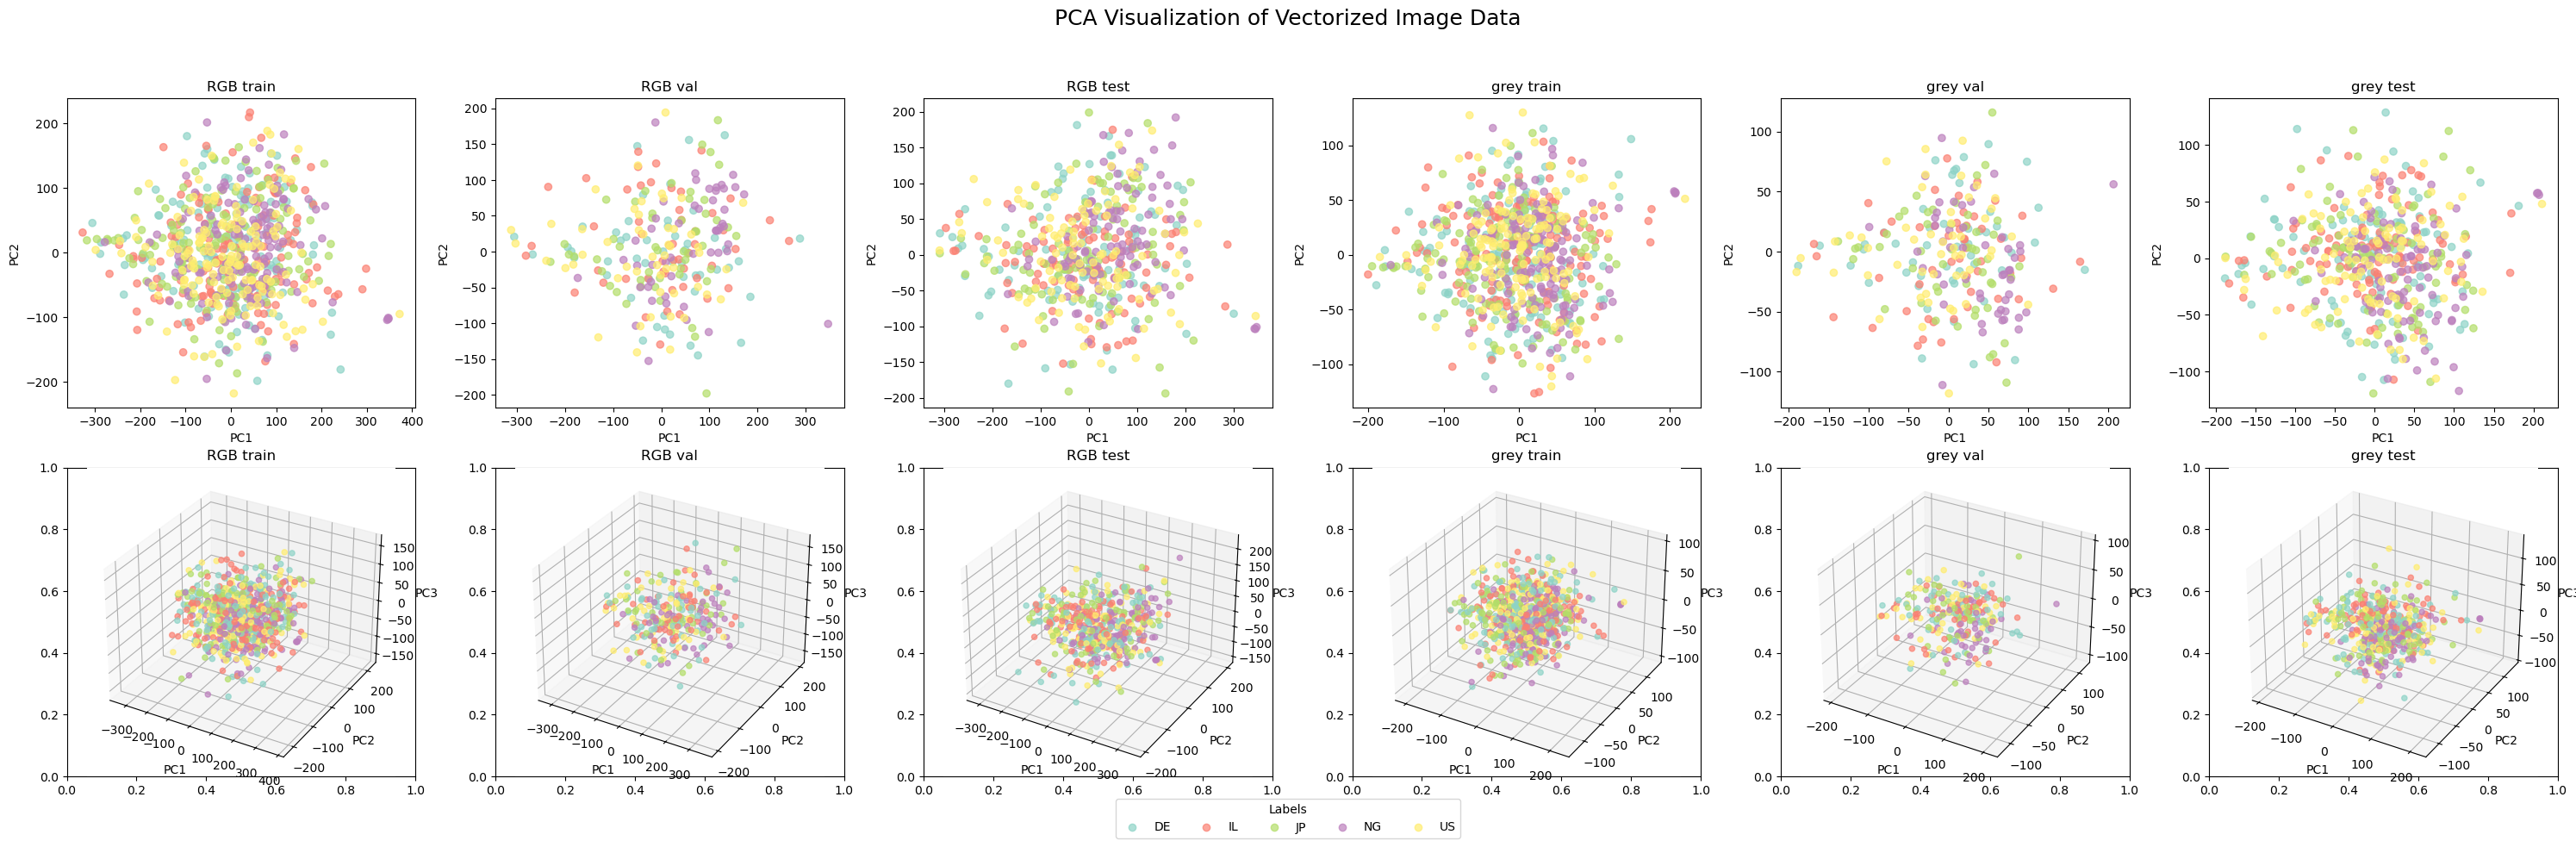

In [73]:
plot_subplots_pca(pca_datasets, sup_title="PCA Visualization of Vectorized Image Data")

As we can observe, the data points just go all around without clear grouping, which is to be expected when we only consider pixels as features. For the next experiment, we will produce image embeddings with VGG-16 pre-trained model across the datasets and see if this can improve PCA projections. 

The first steps will be creating new dataframes such that each picture is represented with the appropriate embedding for later PCA processing

In [74]:
# Image transformation pipeline for the images
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [75]:
# Define wrapper for country211 datasets
class HuggingfaceCountryDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

In [79]:
# Those loaders can be used for future DL models used with Pytorch :)
filtered_ds_loaders = []

for dataset_filtered in datasets_filtered:
    torch_dataset = HuggingfaceCountryDataset(dataset_filtered, transform=img_transform)
    torch_loader = DataLoader(torch_dataset, batch_size=32, shuffle=False)
    filtered_ds_loaders.append(torch_loader)

In [112]:
# Those data-frames can be used for future DL models used with Pytorch :)

vgg_data_frames = []
splits = ("train", "val", "test")

with torch.no_grad():
    for split, torch_loader in zip(splits, filtered_ds_loaders):
        embeddings = []
        embeddings_labels = []
        
        for imgs, lbls in tqdm(torch_loader, desc = f"Embedding {split} data and saving to separate dataframe"):
            imgs = imgs.to(dl_device)
            feats = vgg_embedding_model(imgs)           # (B, 512, 7, 7)
            vecs = feats.view(feats.size(0), -1)     # (B, 25088)
            embeddings.append(vecs.cpu().numpy())
            embeddings_labels.extend(lbls)

        embeddings = np.vstack(embeddings)
        df_vgg_embeddings = pd.DataFrame(embeddings)
        df_vgg_embeddings['label'] = embeddings_labels
        vgg_data_frames.append(df_vgg_embeddings)

Embedding train data and saving to separate dataframe: 100%|██████████████████████████████████| 24/24 [00:08<00:00,  2.74it/s]
Embedding val data and saving to separate dataframe: 100%|██████████████████████████████████████| 8/8 [00:02<00:00,  2.78it/s]
Embedding test data and saving to separate dataframe: 100%|███████████████████████████████████| 16/16 [00:05<00:00,  2.74it/s]


In [113]:
X_y_matrices_vgg = tuple((vgg_df.iloc[:, :-1].to_numpy(), vgg_df.iloc[:, -1].to_numpy()) for vgg_df in vgg_data_frames)

X_train_vgg, y_train_vgg = X_y_matrices_vgg[0]
X_validation_vgg, y_validation_vgg = X_y_matrices_vgg[1]
X_test_vgg, y_test_vgg = X_y_matrices_vgg[2]

In [114]:
vgg_scaler = StandardScaler()
pca_2d, pca_3d = PCA(n_components=2), PCA(n_components=3)
splits = ("train", "val", "test")


vgg_pca_datasets = []

for split, (X_vgg, y_vgg) in zip(splits, X_y_matrices_vgg):
    print(f"Processing PCA for vgg-{split}")
    if split == "train":
        X_vgg_scaled = vgg_scaler.fit_transform(X_vgg)
        X_vgg_scaled_pca2 = pca_2d.fit_transform(X_vgg_scaled)
        X_vgg_scaled_pca3 = pca_3d.fit_transform(X_vgg_scaled)
    else:
        X_vgg_scaled = vgg_scaler.transform(X_vgg)
        X_vgg_scaled_pca2 = pca_2d.transform(X_vgg_scaled)
        X_vgg_scaled_pca3 = pca_3d.transform(X_vgg_scaled)

    labels_vgg = label2country(y_vgg)

    vgg_pca_datasets.append((X_vgg_scaled_pca2, X_vgg_scaled_pca3, labels_vgg, f"vgg {split}"))

Processing PCA for vgg-train
Processing PCA for vgg-val
Processing PCA for vgg-test


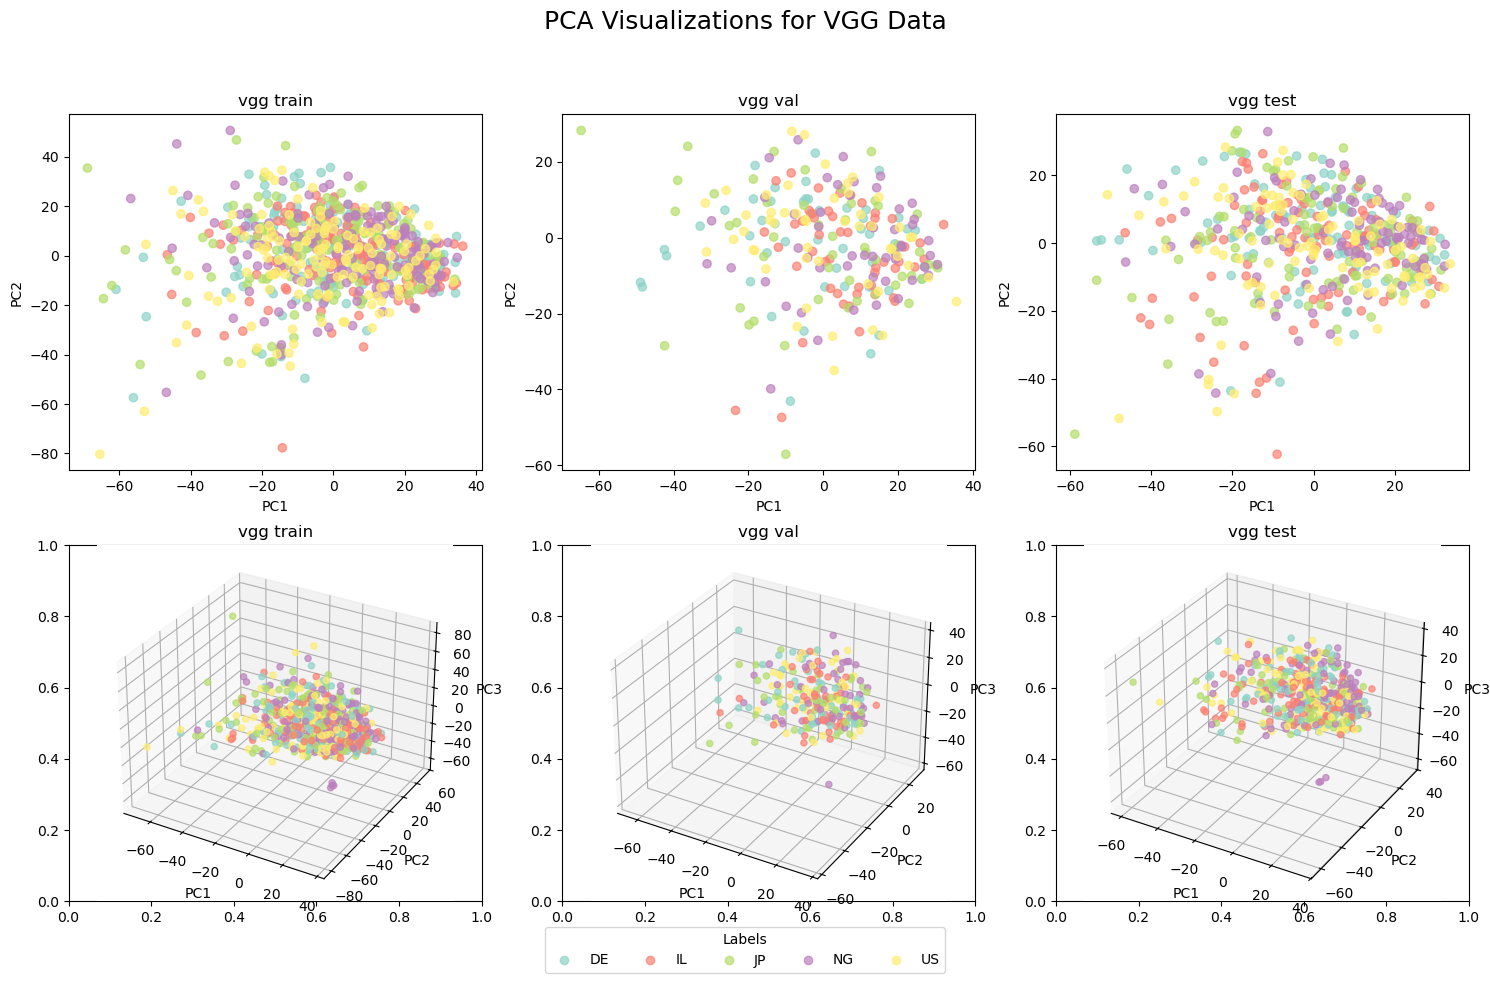

In [115]:
plot_subplots_pca(vgg_pca_datasets, sup_title="PCA Visualizations for VGG Data", file_name="VGG-PCA")

We notice a change in PCA results when using image embeddings, but it is still chaotic and clustering is not as trivial.

Now we will calculate simiality and difference across the different kinds of datasets using cosine similarity.

In [109]:
def plot_similarity_matrix(sim_matrix, labels, title="Cosine Similarity", max_labels=30):
    # Limit to top-N labels for clarity
    sim_matrix = sim_matrix[:max_labels, :max_labels]
    labels = labels[:max_labels]

    fig, ax = plt.subplots(figsize=(11, 8))
    cax = ax.imshow(sim_matrix, cmap='viridis')

    # Color bar
    fig.colorbar(cax)

    # Axis ticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)

    # Title
    ax.set_title(title, fontsize=16)

    # Annotate each cell with similarity value
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                continue
            value = sim_matrix[i, j]
            ax.text(j, i, f"{value:.4f}", ha='center', va='center',
                    color='white', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [166]:
# Create DataFrame with each vector dimension as a separate column
df_flattened_rgb = pd.DataFrame(X_rgb_train)

# Convert numeric labels to strings
labels_str = label2country(df_train_rgb["label"])

# Add labels as a column
df_flattened_rgb["label"] = labels_rgb_train

In [118]:
rgb_data_frames_for_cosine = tuple(
    tuple(df.copy(deep=True) for df in data_frames_rgb_flattened
))

grey_data_frames_for_cosine = tuple(
    tuple(df.copy(deep=True) for df in data_frames_grey_flattened
))

vgg_data_frames_for_cosine = tuple(
    tuple(df.copy(deep=True) for df in vgg_data_frames
))

In [120]:
sim_matrices_rgb, sim_matrices_grey, sim_matrices_vgg = [], [], []

for data_frame in rgb_data_frames_for_cosine:
    data_frame["label"].apply(label2country)

    mean_per_country = data_frame.groupby("label").mean()
    country_names = mean_per_country.index.tolist()
    similarity_matrix = cosine_similarity(mean_per_country)
    sim_matrices_rgb.append((similarity_matrix, country_names))

for data_frame in grey_data_frames_for_cosine:
    data_frame["label"].apply(label2country)

    mean_per_country = data_frame.groupby("label").mean()
    country_names = mean_per_country.index.tolist()
    similarity_matrix = cosine_similarity(mean_per_country)
    sim_matrices_grey.append((similarity_matrix, country_names))

for data_frame in vgg_data_frames_for_cosine:
    data_frame["label"].apply(label2country)

    mean_per_country = data_frame.groupby("label").mean()
    country_names = mean_per_country.index.tolist()
    similarity_matrix = cosine_similarity(mean_per_country)
    sim_matrices_vgg.append((similarity_matrix, country_names))
    

TypeError: iteration over a 0-d tensor

In [172]:
sim_matrix_rgb = cosine_similarity(mean_per_country_rgb)

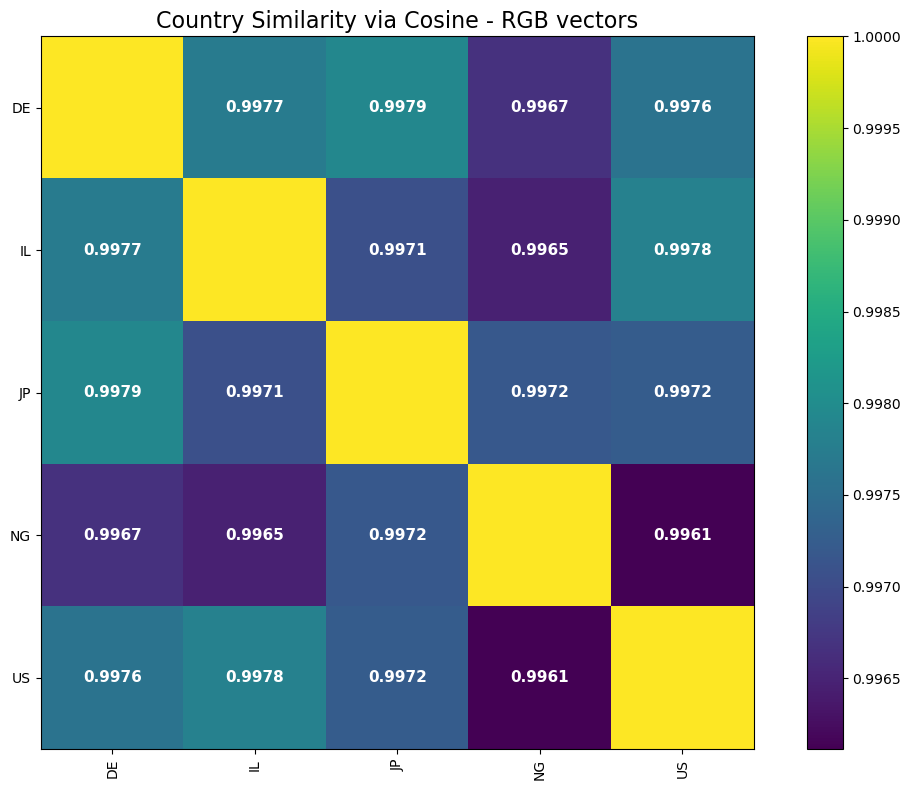

In [173]:
plot_similarity_matrix(sim_matrix_rgb, country_names_rgb, title="Country Similarity via Cosine - RGB vectors")

In [127]:
mean_per_country_vgg = df_vgg_embeddings.groupby("label").mean()
country_names = mean_per_country_vgg.index.tolist()

In [129]:
sim_matrix = cosine_similarity(mean_per_country_vgg)

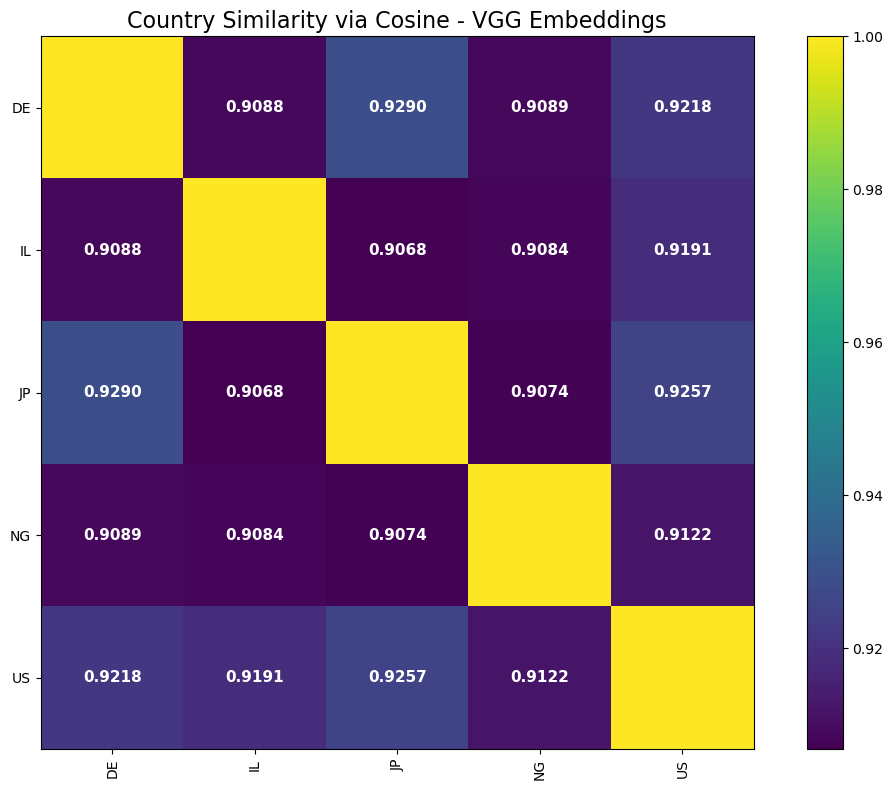

In [156]:
plot_similarity_matrix(sim_matrix, country_names, title="Country Similarity via Cosine - VGG Embeddings")

# Q4 - Model evaluation across datasets

In this section we ask the question of model performance for classification of images. We will use the following strategy:

For rgb and greyscale vectors, we will use the following models: SVM, RF, Adaboost and a custom constructed MLP.

For the original image data, we will fine-tune the Resnet-50 model for our purpose of classifying a country based on the image.

### Traditional ML

For this section, we will train the following models: SVM, RF and Adaboost models. For each model we will benchmark with RGB and greyscale vector data.

In [198]:
# Before beginning, we will remap the labels to values from 0 to 4 and apply it across the dataframes
def remap_labels(df, col_name = "label"):
    unique_vals = df[col_name].unique()
    unique_vals_sorted = sorted(unique_vals)  # sort to keep order consistent

    # Create mapping dictionary from old values to 0..4
    mapping = {old: new for new, old in enumerate(unique_vals_sorted)}

    print(f"DEBUG mapping: {mapping}")

    # Apply mapping to the DataFrame column
    df[col_name] = df[col_name].map(mapping)

    return df

def pre_process_features(df):
    X_flattened = np.stack([np.array(img).reshape(-1) for img in df["image_array"]])
    df_flattened = pd.DataFrame(X_flattened)
    
    # Add labels as a column
    df_flattened["label"] = df["label"]

    return df_flattened

In [213]:
data_frames_to_pre_process = [
    ("RGB datasets", df_train_rgb, df_validation_rgb, df_test_rgb),
    ("Greyscale datasets", df_train_grey, df_validation_grey, df_test_grey)
]

models = {
    "SVM": SVC(),
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

def train_and_evaluate(dataset_name, train_df, val_df, test_df):
    X_train, X_val, X_test = train_df.iloc[:, :-1], val_df.iloc[:, :-1], test_df.iloc[:, :-1]
    y_train, y_val, y_test = train_df.iloc[:, -1], val_df.iloc[:, -1], test_df.iloc[:, -1]

    results = []

    print(f"Training and evaluating for {dataset_name}")
    for name, model in models.items():
        print(f"Training and evaluationg {name}")
        model.fit(X_train, y_train)
        val_acc = accuracy_score(y_val, model.predict(X_val))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        results.append((name, val_acc, test_acc))
        
    return results

In [211]:
processed_data_frames = [
    tuple(pre_process_features(remap_labels(df)) for df in data_tuple[1:])
    for data_tuple in data_frames_to_pre_process
]

DEBUG mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}
DEBUG mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}
DEBUG mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}
DEBUG mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4}


In [212]:
df_train_rgb_rdy, df_validation_rgb_rdy, df_test_rgb_rdy = processed_data_frames[0] 
df_train_grey_rdy, df_validation_grey_rdy, df_test_grey_rdy = processed_data_frames[1] 

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
data_frames_pre_processed = [for (train_df, val_df, test_df) in data_frames_to_pre_process]

In [176]:
df_train_rgb_remapped, rgb_train_mapping = remap_labels(df_train_rgb)

In [210]:
for i, data_frames in enumerate(processed_data_frames):
    data_frames_name, train, val, test = data_frames

    print(f"{train_and_evaluate(data_frames_name, train, val, test)}")

Results for datasets index 0: [('SVM', 0.264, 0.256), ('RandomForest', 0.28, 0.24), ('AdaBoost', 0.236, 0.28)]
Results for datasets index 1: [('SVM', 0.28, 0.25), ('RandomForest', 0.296, 0.242), ('AdaBoost', 0.24, 0.234)]


## Training and evaluating models

In [49]:
X_train, X_validation, X_test = tuple(np.stack(data_frame["image"].values) for data_frame in data_frames)
y_train, y_validation, y_test = tuple(np.stack(data_frame["label"].values) for data_frame in data_frames)


# PCA for dimentionality reduction
X_train_pca, X_validation_pca, X_test_pca = apply_PCA(X_train, y_train), apply_PCA(X_validation, y_validation), apply_PCA(X_test, y_test)

#### SVM

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Step 4: Train SVM
clf = SVC(kernel='linear', C=1.0, gamma='scale')  # you can also try 'linear' kernel
clf.fit(X_train_scaled, y_train)

# Step 5: Evaluate
y_pred = clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.06947368421052631
Classification Report:
               precision    recall  f1-score   support

          14       0.06      0.07      0.06       100
          20       0.07      0.06      0.06       100
          71       0.01      0.01      0.01       100
          74       0.14      0.03      0.05       100
          87       0.08      0.02      0.03       100
          92       0.09      0.32      0.14       100
          99       0.00      0.00      0.00       100
         102       0.00      0.00      0.00       100
         103       0.00      0.00      0.00       100
         106       0.05      0.03      0.04       100
         116       0.10      0.08      0.09       100
         121       0.06      0.21      0.09       100
         130       0.50      0.01      0.02       100
         149       0.07      0.26      0.11       100
         151       0.00      0.00      0.00       100
         179       0.06      0.17      0.09       100
         188       0.09    

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

#### Random Forest

In [54]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.08894736842105264
Classification Report:
               precision    recall  f1-score   support

          14       0.04      0.04      0.04       100
          20       0.05      0.06      0.05       100
          71       0.08      0.07      0.07       100
          74       0.11      0.15      0.13       100
          87       0.08      0.06      0.07       100
          92       0.08      0.13      0.10       100
          99       0.08      0.05      0.06       100
         102       0.18      0.17      0.18       100
         103       0.09      0.07      0.08       100
         106       0.08      0.08      0.08       100
         116       0.12      0.15      0.13       100
         121       0.06      0.07      0.06       100
         130       0.05      0.04      0.05       100
         149       0.10      0.17      0.13       100
         151       0.14      0.08      0.10       100
         179       0.08      0.07      0.07       100
         188       0.10    

#### Resnet - Deep CNN Model

As a general rule, all the pre-processing of above models wont apply. This section will handle pre-processing and fine-tuning for Resnet specifically

In [11]:
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from PIL import Image

In [12]:
resnet50 = models.resnet50(pretrained=True)

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
datasets_for_resnet = datasets_filtered

In [14]:
num_classes = 20
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
label_white_list

array([ 30, 173, 140,  75,  60, 208,  45, 183,   9, 100, 137, 204, 156,
        82,  15, 200, 167,  18, 209,  86])

In [17]:
len(label_white_list)

20

In [18]:
label_map = {old: new for new, old in enumerate(label_white_list)}

In [19]:
label_map

{np.int64(30): 0,
 np.int64(173): 1,
 np.int64(140): 2,
 np.int64(75): 3,
 np.int64(60): 4,
 np.int64(208): 5,
 np.int64(45): 6,
 np.int64(183): 7,
 np.int64(9): 8,
 np.int64(100): 9,
 np.int64(137): 10,
 np.int64(204): 11,
 np.int64(156): 12,
 np.int64(82): 13,
 np.int64(15): 14,
 np.int64(200): 15,
 np.int64(167): 16,
 np.int64(18): 17,
 np.int64(209): 18,
 np.int64(86): 19}

In [20]:
len(label_map)

20

In [21]:
class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, label_map = label_map):
        self.dataset = hf_dataset
        self.transform = transform
        self.label_map = label_map
        

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        if isinstance(image, torch.Tensor):
            image = TF.to_pil_image(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        label = int(sample["label"]) # Remap to 0–19
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)

In [22]:
train_ds = HFImageDataset(datasets_for_resnet[0].with_format("torch"), transform=transform)
val_ds = HFImageDataset(datasets_for_resnet[1].with_format("torch"), transform=transform)

In [23]:
img, label = train_ds[3]
label

8

In [24]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [25]:
print("train_ds type:", type(train_ds))  # should be HFImageDataset
print("Sample:", train_ds[0][0].shape) 

train_ds type: <class '__main__.HFImageDataset'>
Sample: torch.Size([3, 224, 224])


In [26]:


# Training loop
for epoch in range(5):  # Choose your number of epochs
    resnet50.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed.")

cuda


100%|███████████████████████████████████████████| 94/94 [00:21<00:00,  4.44it/s]


Epoch 1 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.60it/s]


Epoch 2 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.57it/s]


Epoch 3 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 4 completed.


100%|███████████████████████████████████████████| 94/94 [00:27<00:00,  3.41it/s]

Epoch 5 completed.


In [27]:
train_losses = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)

for epoch in range(5):
    resnet50.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

cuda


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.49it/s]


Epoch 1 completed. Avg Loss: 0.0875


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.48it/s]


Epoch 2 completed. Avg Loss: 0.1623


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.41it/s]


Epoch 3 completed. Avg Loss: 0.1038


100%|███████████████████████████████████████████| 94/94 [00:38<00:00,  2.44it/s]


Epoch 4 completed. Avg Loss: 0.0551


100%|███████████████████████████████████████████| 94/94 [00:38<00:00,  2.44it/s]

Epoch 5 completed. Avg Loss: 0.0462


In [31]:
def get_image_data(dataset_split, index: int, as_array = True) -> (np.ndarray | Image, int):
    image_sample = dataset_split[index]
    image, label = np.array(image_sample["image"]) if as_array else image_sample["image"], image_sample["label"]

    return image, label
    

TypeError: unsupported operand type(s) for |: 'type' and 'module'

In [16]:
# Convert to numpy arrays for convenience

label_array = np.array(ds['label'])

In [73]:
example = ds[1]
img = example["image"].convert("L")   # a PIL Image object
label = example["label"] # integer 0–210 representing country


In [74]:
img.show()
